In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import SpectralBiclustering
# Run this when it is ready
# !pip install -i https://test.pypi.org/simple/ ssvd-pkg-cathy10
# from ssvd_pkg import ssvd_original, ssvd_new
# Uncomment this
from algorithms import * 

# Simulation 1 - Rank 1 Approximation

In [2]:
u_tilde = np.concatenate((np.arange(10,2,-1), 2*np.ones(17), np.zeros(75)))[:,None]
u_true = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)))[:,None]
v_true = v_tilde/np.linalg.norm(v_tilde)
X_star = 50*u_true*v_true.T
n, d = X_star.shape
np.random.seed(0)
nsims = 100
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [3]:
u_true_labels = u_true == 0
v_true_labels = v_true == 0

## Optimization

In [4]:
ssvd_u_preds_original, ssvd_v_preds_original, ssvd_s_values_original = list(zip(*list(map(ssvd_original, sims))))

In [5]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds_original)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds_original)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [6]:
ssvd_u_preds_sparsesvd, ssvd_v_preds_sparsesvd, ssvd_s_values_sparsesvd = list(zip(*list(map(lambda x : ssvd_original(x, sparse_decomp = True), sims))))

In [7]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds_sparsesvd)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds_sparsesvd)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [8]:
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd_new, sims))))

In [9]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [10]:
# Ensure that the signs of the singular vectors are the same, for comparison
print(np.allclose(tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_u_preds_original)), 
                  tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_u_preds_sparsesvd)), atol = 1e-1))
print(np.allclose(tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_v_preds_original)), 
                  tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_v_preds_sparsesvd)), atol = 1e-1))
print(np.allclose(ssvd_s_values_original, ssvd_s_values_sparsesvd, atol = 1e-4))

print(np.allclose(ssvd_u_preds_original, ssvd_u_preds, atol = 1e-4))
print(np.allclose(ssvd_v_preds_original, ssvd_v_preds, atol = 1e-4))
print(np.allclose(ssvd_s_values_original, ssvd_s_values, atol = 1e-4))

True
True
True
True
True
True


In [11]:
%%timeit
ssvd_u_preds_original, ssvd_v_preds_original, ssvd_s_values_original = list(zip(*list(map(ssvd_original, sims))))

4.63 s ± 1.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
ssvd_u_preds_sparsesvd, ssvd_v_preds_sparsesvd, ssvd_s_values_sparsesvd = list(zip(*list(map(lambda x : ssvd_original(x, sparse_decomp = True), sims))))

2.95 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd_new, sims))))

876 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison with other algorithms

### SVD

In [14]:
svd_u_preds, svd_v_preds = list(zip(*list(map(lambda x : (x[0][:,0][:,None], x[2][0,:][:,None]), map(lambda x : np.linalg.svd(x, full_matrices = False), sims)))))

In [15]:
print("SVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), svd_u_preds)))*100))
print("SVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), svd_v_preds)))*100))

SVD Misclassification rate for u is 75.00%
SVD Misclassification rate for v is 68.00%


### Spectral Clustering

In [16]:
sc_u_preds, sc_v_preds = list(zip(*list(map(lambda x : (x.row_labels_, x.column_labels_), map(lambda x : SpectralBiclustering(n_clusters=2, random_state=0).fit(x), sims)))))

In [17]:
sc_u_wrong = np.mean(list(map(lambda x : min(np.mean((x == 0) != u_true_labels), np.mean((x == 1) != u_true_labels)), sc_u_preds)))*100
sc_v_wrong = np.mean(list(map(lambda x : min(np.mean((x == 0) != v_true_labels), np.mean((x == 1) != v_true_labels)), sc_v_preds)))*100
print("Spectral Clusting Misclassification rate for u is {0:.2f}%".format(sc_u_wrong))
print("Spectral Clusting Misclassification rate for v is {0:.2f}%".format(sc_v_wrong))

Spectral Clusting Misclassification rate for u is 47.11%
Spectral Clusting Misclassification rate for v is 37.74%


# Simulation 2 - Higher Rank Approximation

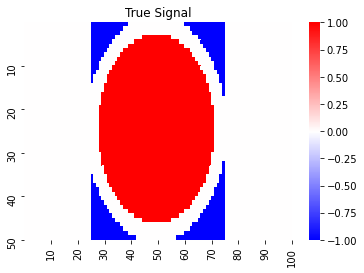

In [18]:
X_star = np.fromfunction(lambda i, j: np.where((25 <= j) & (j <= 74), (24**2 - (i+1-25)**2 - (j+1-50)**2)/100, 0), (50,100)) # like ternary
X_star *= (np.abs(X_star) > 1)
ax = sns.heatmap(X_star, vmin = -1, vmax = 1, cmap = 'bwr')
ax.set_title("True Signal");
xticks = np.arange(10,110,10)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
yticks = np.arange(10,60,10)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks);

In [19]:
nsims = 100
n, d = X_star.shape
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

## Comparison with other algorithms

In [20]:
sims_copy = copy.deepcopy(sims)
layers = 8
ssvd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    # Failure of convergence is expected at high number of layers, given that most information is already extracted by then.
    ssvd_predictions = np.array(list(map(lambda x : x[2] * x[0] @ x[1].T, map(lambda x : ssvd_new(x, tol = 1e-3, max_iter = 40), sims_copy))))
    ssvd_estimates[i] = ssvd_predictions
    sims_copy -= ssvd_predictions

In [21]:
svd_decomps = list(map(lambda x : np.linalg.svd(x, full_matrices = False), sims_copy))
svd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    svd_estimates[i] = np.array(list(map(lambda x : x[1][i] * x[0][:,i][:,None] @ x[2][i,:][None,:],svd_decomps)))

In [22]:
for i in range(1, layers):
    ssvd_estimates[i] += ssvd_estimates[i-1]
    svd_estimates[i] += svd_estimates[i-1]

In [23]:
ssvd_classification = []
svd_classification = []
X_star_labels = X_star == 0
for i in range(layers):
    ssvd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), ssvd_estimates[i])))))
    svd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), svd_estimates[i])))))

In [24]:
max_equal = lambda x : max(np.mean(x == (X_star == 0)), np.mean(x == (X_star != 0)))
sc_classification = list(map(lambda num_layers : 
                             np.mean(list(map(lambda x : max(max_equal(x.row_labels_[:, None] @ x.column_labels_[None, :]),
                                                             max_equal((x.row_labels_[:, None] == 0) @ x.column_labels_[None, :]), 
                                                             max_equal(x.row_labels_[:, None] @ (x.column_labels_[None, :] == 0)), 
                                                             max_equal((x.row_labels_[:, None] == 0) @ (x.column_labels_[None, :] == 0))), 
                                              map(lambda x : SpectralBiclustering(n_clusters=2, random_state=0, n_components = num_layers, n_best = min(3, num_layers)).fit(x), sims)))), np.arange(1,9)))

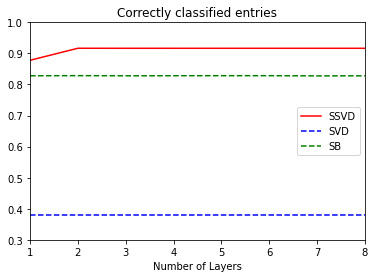

In [25]:
plt.plot(np.arange(1,9), ssvd_classification, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_classification, label = "SVD", color = "blue", linestyle = "dashed")
plt.plot(np.arange(1,9), sc_classification, label = "SB", color = "green", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.ylim([0.3, 1])
plt.xlim([1, 8])
plt.title("Correctly classified entries")
plt.legend();

# Real Dataset 1 - Lung Cancer Data (In Paper)

## Optimization

Since this takes a long time, we only time how long it takes to extract the first SSVD layer.

In [26]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [27]:
%%time
u1_original, v1_original, s1_original = ssvd_original(X_lung)

CPU times: user 10min 5s, sys: 2min 28s, total: 12min 34s
Wall time: 6min 46s


In [28]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [29]:
%%time
u1_sparsesvd, v1_sparsesvd, s1_sparsesvd = ssvd_original(X_lung, sparse_decomp = True)

CPU times: user 9min 24s, sys: 1min 57s, total: 11min 21s
Wall time: 6min 8s


In [30]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [31]:
%%time
u1, v1, s1 = ssvd_new(X_lung)

CPU times: user 8min 30s, sys: 2min 15s, total: 10min 45s
Wall time: 5min 43s


In [32]:
print(np.allclose(np.r_[u1_original, v1_original, np.array([s1_original])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))

print(np.allclose(np.r_[u1_sparsesvd, v1_sparsesvd, np.array([s1_sparsesvd])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))

True
True


In [34]:
X_lung -= s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_lung)
X_lung -= s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_lung)

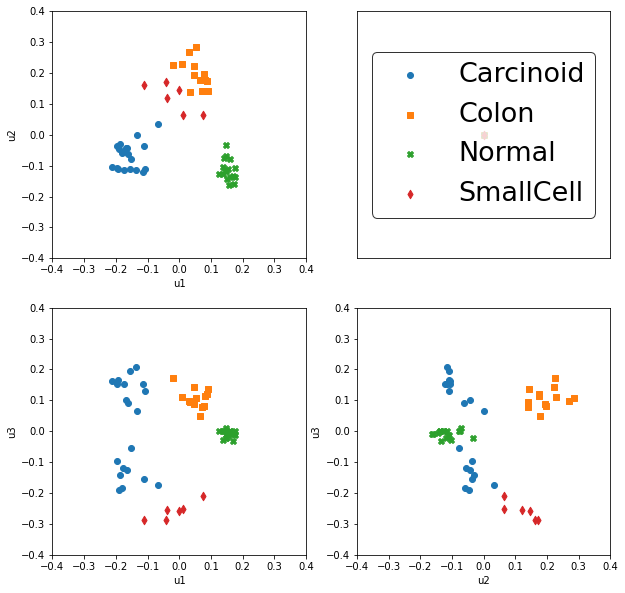

In [35]:
group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
markers = ["o", "s", "X", "d"]
labels = ["Carcinoid", "Colon", "Normal", "SmallCell"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [36]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0)[8000:].flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [37]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [38]:
def plot_lung(X, title, xticks, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([20, 33, 50], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.vlines([xticks[0], xticks[1]-8000], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_xticks((xticks[0], xticks[1]-8000)) 
    ax.set_xticklabels((str(xticks[0]), str(xticks[1])), rotation = 0)
    ax.set_yticks((10, 27, 42, 53)) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Ordered gene index");

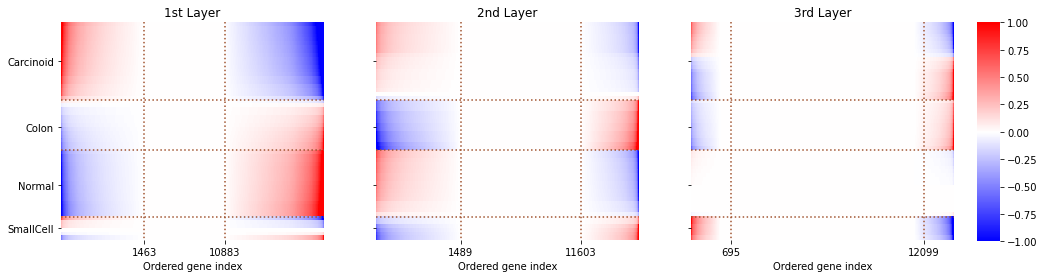

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_lung(X1, "1st Layer", [1463, 10883], ax1, cbar_ax, ("Carcinoid", "Colon", "Normal", "SmallCell"))
plot_lung(X2, "2nd Layer", [1489, 11603], ax2, cbar_ax, ())
plot_lung(X3, "3rd Layer", [695, 12099], ax3, cbar_ax, ())

# Real Dataset 2 - Company Financial Fraud Data (Not In Paper)

In [40]:
X_com = np.loadtxt('company.txt').T

In [41]:
%%timeit
u1, v1, s1 = ssvd_original(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_original(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_com)

27.3 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
X_com = np.loadtxt('company.txt').T
u1_original, v1_original, s1_original = ssvd_original(X_com)
X_com2 = X_com - s1_original*(u1_original @ v1_original.T)
u2_original, v2_original, s2_original = ssvd_original(X_com2)
X_com3 = X_com2 - s2_original*(u2_original @ v2_original.T)
u3_original, v3_original, s3_original = ssvd_original(X_com3)

In [43]:
X_com = np.loadtxt('company.txt').T

In [44]:
%%timeit
u1, v1, s1 = ssvd_original(X_com, sparse_decomp = True)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_original(X_com2, sparse_decomp = True)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_com3, sparse_decomp = True)

29.9 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
X_com = np.loadtxt('company.txt').T
u1_sparsesvd, v1_sparsesvd, s1_sparsesvd = ssvd_original(X_com, sparse_decomp = True)
X_com2 = X_com - s1_sparsesvd*(u1_sparsesvd @ v1_sparsesvd.T)
u2_sparsesvd, v2_sparsesvd, s2_sparsesvd = ssvd_original(X_com2, sparse_decomp = True)
X_com3 = X_com2 - s2_sparsesvd*(u2_sparsesvd @ v2_sparsesvd.T)
u3_sparsesvd, v3_sparsesvd, s3_sparsesvd = ssvd_original(X_com3, sparse_decomp = True)

In [46]:
X_com = np.loadtxt('company.txt').T

In [47]:
%%timeit
u1, v1, s1 = ssvd_new(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_new(X_com3)

3.26 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
X_com = np.loadtxt('company.txt').T
u1, v1, s1 = ssvd_new(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_new(X_com3)

In [49]:
print(np.allclose(np.r_[u1_original, v1_original, np.array([s1_original])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))
print(np.allclose(np.r_[u2_original, v2_original, np.array([s2_original])[:, None]], 
                  np.r_[u2, v2, np.array([s2])[:, None]], atol = 1e-5))
print(np.allclose(np.r_[u3_original, v3_original, np.array([s3_original])[:, None]], 
                  np.r_[u3, v3, np.array([s3])[:, None]], atol = 1e-3))

print(np.allclose(np.r_[u1_sparsesvd, v1_sparsesvd, np.array([s1_sparsesvd])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))
print(np.allclose(np.r_[-u2_sparsesvd, -v2_sparsesvd, np.array([s2_sparsesvd])[:, None]], 
                  np.r_[u2, v2, np.array([s2])[:, None]], atol = 1e-5))
print(np.allclose(np.r_[u3_sparsesvd, v3_sparsesvd, np.array([s3_sparsesvd])[:, None]], 
                  np.r_[u3, v3, np.array([s3])[:, None]], atol = 1e-3))

True
True
True
True
True
True


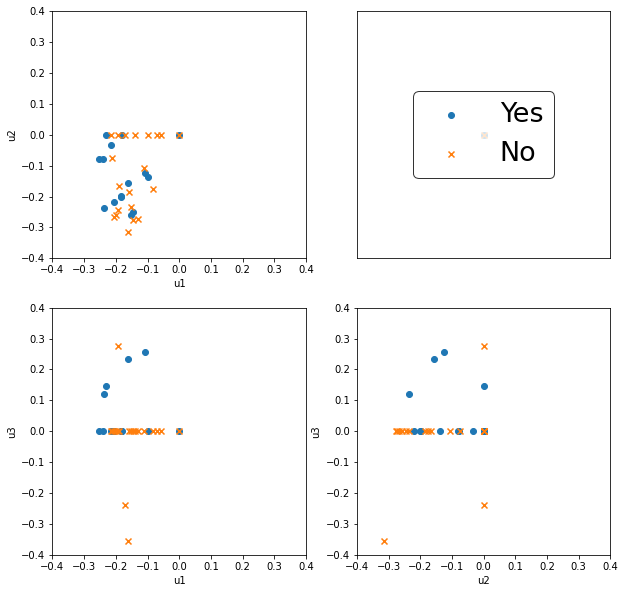

In [50]:
group_indices = [np.arange(15), np.arange(15,35)]
markers = ["o", "x"]
labels = ["Yes", "No"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [51]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(15), np.arange(15,35)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0).flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [52]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [53]:
def plot_comp(X, title, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([15], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_yticks([7.5, 25]) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Company index");

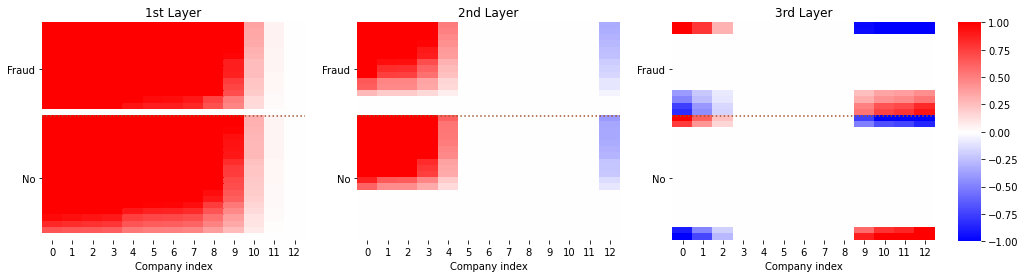

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_comp(X1, "1st Layer", ax1, cbar_ax, ("Fraud", "No"))
plot_comp(X2, "2nd Layer", ax2, cbar_ax, ("Fraud", "No"))
plot_comp(X3, "3rd Layer", ax3, cbar_ax, ("Fraud", "No"))